In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.nn.functional import pad
from torch.utils.data import DataLoader
from torch.jit import load

from rtid.datasets.dataset import DatasetTPC

In [2]:
dataset = DatasetTPC('/data/sphenix/auau/highest_framedata_3d/outer/test.txt',
                     dimension = 2,
                     axis_order = ('layer', 'azimuth', 'beam'))
batch_size = 1
dataloader = DataLoader(dataset, batch_size = batch_size)

load Au + Au TPC data in ('layer', 'azimuth', 'beam')


In [3]:
ROOT = Path('/home/yhuang2/PROJs/rtid/rtid/ae2d/')
ae_type = 'bcae'
num_decoder_layers = 6
checkpoints = ROOT/ae_type/f'checkpoints_decoder-{num_decoder_layers}'
enc_pth = checkpoints/'enc_last.pth'
dec_pth = checkpoints/'dec_last.pth'
enc_pth.exists()

encoder = load(enc_pth).cuda()
decoder = load(dec_pth).cuda()
_ = encoder.eval()
_ = decoder.eval()
print(checkpoints)

/home/yhuang2/PROJs/rtid/rtid/ae2d/bcae/checkpoints_decoder-6


In [4]:
# loss_fn = nn.MSELoss()
# mse = []
# with torch.no_grad():
#     for batch in tqdm(dataloader):
#         batch = batch.cuda()
#         comp = encoder(pad(batch, (0, 7)))
#         decomp = decoder(comp)[..., :-7]
#         loss = loss_fn(decomp, batch).item()
#         mse.append(loss)

In [5]:
# mean = np.mean(mse)
# std = np.mean(mse)
# print(mean, std)
# np.savetxt(checkpoints/'mse_test.csv', mse, newline = '\n', fmt = '%.3f')

In [6]:
# fig, ax = plt.subplots(1, 1)
# sns.histplot(mse, ax = ax, bins = 75)
# ax.axvline(mean, color='orange', label=f'mean={mean:.3f}')
# ax.set_xlim(0, 700)
# ax.legend()
# ax.set_title(f'{ae_type.upper()}, decoder layers = {num_decoder_layers}')
# fig.savefig(f'results/{ae_type}_decoder-{num_decoder_layers}.png', dpi = 200, bbox_inches = 'tight', transparent = True)

In [7]:
threshold = .5
loss_fn = nn.MSELoss()
mag, mse, precision, recall = [], [], [], []

with torch.no_grad():
    pbar = tqdm(f'{ae_type}, decoder = {num_decoder_layers}', total = len(dataloader))
    for batch in dataloader:
        batch = batch.cuda()
        mag.append(torch.pow(batch, 2).mean().item())
        
        comp = encoder(pad(batch, (0, 7)))
        clf, reg = decoder(comp)
        
        clf = clf[..., :-7]
        reg = reg[..., :-7]
        
        # reg = torch.clamp(reg, max = 5.08)
        # reg = torch.exp(reg) * 6 + 64
        mask = clf > threshold
        decomp = reg * mask
        loss = loss_fn(decomp, batch).item()
        mse.append(loss)
        
        pos = mask.sum()
        tag = batch > 0
        true = tag.sum()
        true_pos = (mask * tag).sum()
        precision.append((true_pos / pos).item())
        recall.append((true_pos / true).item())
        
        pbar.update()
        pbar.set_postfix({'mag': mag[-1],
                          'mse': mse[-1], 
                          'precision': precision[-1], 
                          'recall': recall[-1]})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6288/6288 [00:38<00:00, 174.24it/s, mag=1.43e+3, mse=166, precision=0.891, recall=0.887]

In [8]:
df = pd.DataFrame(data = {'mag': mag, 'mse': mse, 'precision': precision, 'recall': recall})
df['mse_mag_ratio'] = df['mse'] / df['mag']
df.to_csv(checkpoints/'stat_text.csv', index = False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6288/6288 [00:50<00:00, 174.24it/s, mag=1.43e+3, mse=166, precision=0.891, recall=0.887]

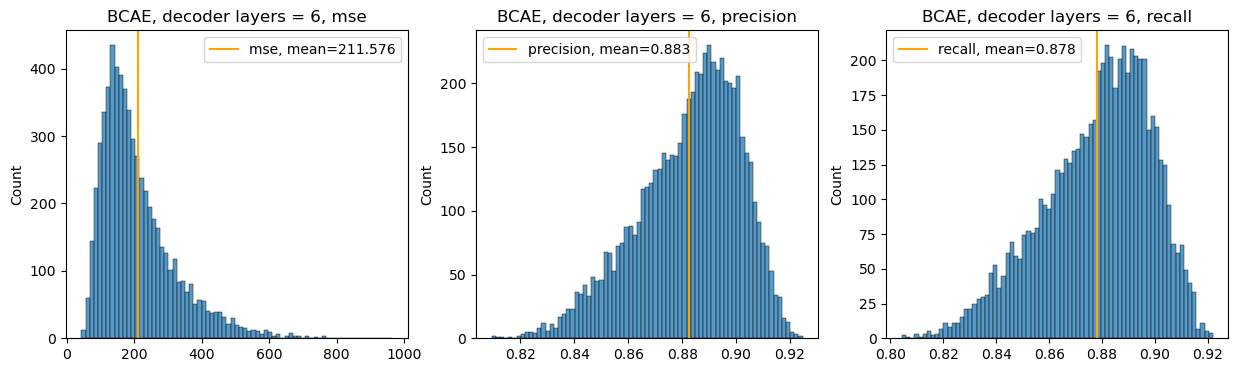

In [9]:
width, height = 5, 4
fig, axes = plt.subplots(1, 3, figsize=(3 * width, height))

for col, ax in zip(['mse', 'precision', 'recall'], axes):
    sns.histplot(df[col].values, ax = ax, bins = 75)
    mean = df[col].mean()
    ax.axvline(mean, color='orange', label=f'{col}, mean={mean:.3f}')
    # ax.set_xlim(0, 700)
    ax.legend()
    ax.set_title(f'{ae_type.upper()}, decoder layers = {num_decoder_layers}, {col}')

fig.savefig(f'results/{ae_type}_decoder-{num_decoder_layers}.png', dpi = 600, bbox_inches = 'tight', transparent = True)